In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from imp import reload
import torch.nn as nn

import sys
sys.path.append("..")
import vnn
import vec_models
import nonvec_models
import train_models
from scipy.stats import pearsonr
reload(vnn)


<module 'vnn' from '../vnn.py'>

In [2]:
#Make vectorized inputs
#(unvectorized inputs are called mnist_data and cifar_data)

train_loader, test_loader = train_models.load_cifar()
for cifar_data, cifar_labels in train_loader:
    break
cifar_input_conv = vnn.expand_input_conv(cifar_data, 10)
cifar_input_flat = vnn.expand_input(nn.Flatten()(cifar_data), 10)

train_loader, test_loader = train_models.load_mnist()
for mnist_data, mnist_labels in train_loader:
    break
mnist_input_conv = vnn.expand_input_conv(mnist_data, 10)
mnist_input_flat = vnn.expand_input(nn.Flatten()(mnist_data), 10)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
def compute_alignment_angles(model_dir, make_model_fn, input, labels, num_epochs, epoch_step):
    batch_size = len(input)
    num_checkpoints = len(np.arange(0, num_epochs, epoch_step))
    loss_vals = np.zeros((num_checkpoints, 2))
    acc_vals = np.zeros((num_checkpoints, 2))
    angles = None
    epoch_idx = 0
    for epoch in np.arange(0, num_epochs, epoch_step):
        print(epoch)
        checkpoint = torch.load(model_dir + "/epoch_{}.pt".format(epoch))
        model = make_model_fn()
        model.load_state_dict(checkpoint["model_state_dict"])
        nonlin_layers = [i for i, layer in enumerate(model) if layer.__class__.__name__ in ('tReLU', 'ctReLU')]
        vnn.zero_grads(model)
        output = model(input)[..., 0]
        g_vals = vnn.set_model_grads(model, output, labels, learning_rule="bp", reduction="mean", return_g=True)
        #g_vals = [g_vals[i].view(len(g_vals[i]), -1).numpy() for i in layers]
        g_vals = g_vals[::-1][1:]
        g_vals = [g_vals[i].view(len(g_vals[i]), -1).numpy() for i in nonlin_layers]
        r_vals = np.array([g.sum(axis=1)/(np.linalg.norm(g, axis=1)*np.sqrt(g.shape[1])) for g in g_vals]).T
        if angles is None:
            angles = np.zeros((num_checkpoints, batch_size, len(nonlin_layers)))
        angles[epoch_idx] = np.rad2deg(np.arccos(r_vals))
        loss_vals[epoch_idx] = [checkpoint["train_loss"], checkpoint["test_loss"]]
        acc_vals[epoch_idx] = [checkpoint["train_accuracy"], checkpoint["test_accuracy"]]
        epoch_idx += 1
    return angles, acc_vals, loss_vals

In [11]:
base_dir = "/home/davidclark/Projects/VectorizedNets/experiments/models"

angles_1, acc_1, loss_1 = compute_alignment_angles(
    model_dir=base_dir + "/mnist_vec_fc_df_mono",
    make_model_fn=lambda: vec_models.make_mnist_vec_fc(False),
    input=mnist_input_flat,
    labels=mnist_labels,
    num_epochs=200,
    epoch_step=10)

angles_2, acc_2, loss_2 = compute_alignment_angles(
    model_dir=base_dir + "/mnist_vec_conv_df_mono",
    make_model_fn=lambda: vec_models.make_mnist_vec_conv(False),
    input=mnist_input_conv,
    labels=mnist_labels,
    num_epochs=200,
    epoch_step=10)

angles_3, acc_3, loss_3 = compute_alignment_angles(
    model_dir=base_dir + "/mnist_vec_lc_df_mono",
    make_model_fn=lambda: vec_models.make_mnist_vec_lc(False),
    input=mnist_input_conv,
    labels=mnist_labels,
    num_epochs=100,
    epoch_step=10)

angles_4, acc_4, loss_4 = compute_alignment_angles(
    model_dir=base_dir + "/cifar_vec_fc_df_mono",
    make_model_fn=lambda: vec_models.make_cifar_vec_fc(False),
    input=cifar_input_flat,
    labels=cifar_labels,
    num_epochs=200,
    epoch_step=10)

angles_5, acc_5, loss_5 = compute_alignment_angles(
    model_dir=base_dir + "/cifar_vec_conv_df_mono",
    make_model_fn=lambda: vec_models.make_cifar_vec_conv(False),
    input=cifar_input_conv,
    labels=cifar_labels,
    num_epochs=200,
    epoch_step=10)

angles_6, acc_6, loss_6 = compute_alignment_angles(
    model_dir=base_dir + "/cifar_vec_lc_df_mono",
    make_model_fn=lambda: vec_models.make_cifar_vec_lc(False),
    input=cifar_input_conv,
    labels=cifar_labels,
    num_epochs=100,
    epoch_step=10)



0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90


In [14]:
angles_7, acc_7, loss_7 = compute_alignment_angles(
    model_dir=base_dir + "/mnist_vec_fc_df_mixed",
    make_model_fn=lambda: vec_models.make_mnist_vec_fc(False),
    input=mnist_input_flat,
    labels=mnist_labels,
    num_epochs=200,
    epoch_step=10)

angles_8, acc_8, loss_8 = compute_alignment_angles(
    model_dir=base_dir + "/mnist_vec_conv_df_mixed",
    make_model_fn=lambda: vec_models.make_mnist_vec_conv(False),
    input=mnist_input_conv,
    labels=mnist_labels,
    num_epochs=200,
    epoch_step=10)

angles_9, acc_9, loss_9 = compute_alignment_angles(
    model_dir=base_dir + "/mnist_vec_lc_df_mixed",
    make_model_fn=lambda: vec_models.make_mnist_vec_lc(False),
    input=mnist_input_conv,
    labels=mnist_labels,
    num_epochs=100,
    epoch_step=10)

angles_10, acc_10, loss_10 = compute_alignment_angles(
    model_dir=base_dir + "/cifar_vec_fc_df_mixed",
    make_model_fn=lambda: vec_models.make_cifar_vec_fc(False),
    input=cifar_input_flat,
    labels=cifar_labels,
    num_epochs=200,
    epoch_step=10)

angles_11, acc_11, loss_11 = compute_alignment_angles(
    model_dir=base_dir + "/cifar_vec_conv_df_mixed",
    make_model_fn=lambda: vec_models.make_cifar_vec_conv(False),
    input=cifar_input_conv,
    labels=cifar_labels,
    num_epochs=200,
    epoch_step=10)

angles_12, acc_12, loss_12 = compute_alignment_angles(
    model_dir=base_dir + "/cifar_vec_lc_df_mixed",
    make_model_fn=lambda: vec_models.make_cifar_vec_lc(False),
    input=cifar_input_conv,
    labels=cifar_labels,
    num_epochs=100,
    epoch_step=10)



0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0
10
20
30
40
50
60
70
80
90


In [94]:
colors = ["red", "black", "blue", "green"]
colors = ["#c02e1c", "#1394b9", "#f16b20", "#0c3b55"]
colors = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a"]
colors = ["blue", "red", "green", "purple"]

def make_axes():
    fig = plt.figure(figsize=(7, 4), dpi=150)
    hpad = 0.05
    hspace = 0.05
    vpad = 0.05
    vspace = 0.05
    vmid = 0.020

    h_sub = 0.1
    w = (1 - 2*hspace - 2*hpad)/3.
    h = (1 - 2*vspace - 2*vpad - 2*h_sub - 2*vmid)/2.

    ax1 = fig.add_axes((hpad, vpad + h_sub + h + hspace + h_sub + 2*vmid, w, h))
    ax2 = fig.add_axes((hpad + w + hspace, vpad + h_sub + h + hspace + h_sub + 2*vmid, w, h))
    ax3 = fig.add_axes((hpad + 2*w + 2*hspace, vpad + h_sub + h + hspace + h_sub + 2*vmid, w, h))

    ax1sub = fig.add_axes((hpad, vpad + h_sub + h + hspace + vmid, w, h_sub))
    ax2sub = fig.add_axes((hpad + w + hspace, vpad + h_sub + h + hspace + vmid, w, h_sub))
    ax3sub = fig.add_axes((hpad + 2*w + 2*hspace, vpad + h_sub + h + hspace + vmid, w, h_sub))

    ax4 = fig.add_axes((hpad, vpad + h_sub + vmid, w, h))
    ax5 = fig.add_axes((hpad + w + hspace, vpad + h_sub + vmid, w, h))
    ax6 = fig.add_axes((hpad + 2*w + 2*hspace, vpad + h_sub + vmid, w, h))

    ax4sub = fig.add_axes((hpad, vpad, w, h_sub))
    ax5sub = fig.add_axes((hpad + w + hspace, vpad, w, h_sub))
    ax6sub = fig.add_axes((hpad + 2*w + 2*hspace, vpad, w, h_sub))

    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    axes_sub = [ax1sub, ax2sub, ax3sub, ax4sub, ax5sub, ax6sub]

    for ax in axes + axes_sub:
        ax.set_xticks([])
        ax.set_yticks([])
        
    return axes, axes_sub

def plot_angles(ax, angles, title=None, labels=None):
    n = angles.shape[-1]
    for i in range(n):
        x = angles[:, :, i]
        mu = np.nanmean(x, axis=1)
        std = np.nanstd(x, axis=1)
        print(np.mean(~np.isnan(x)))
        c = colors[n - 1 - i]
        ax.plot(mu, lw=1, color=c, label=labels[i] if labels is not None else str(i))
        ax.fill_between(np.arange(len(x)), mu-std, mu+std, alpha=0.3, color=c, lw=0)
    ax.set_title(title, pad=0, fontsize=10)
    ax.set_ylim(-2.5, 92.5)
    ax.set_yticks([0, 15, 30, 45, 60, 75, 90])
    ax.tick_params(size=3, labelsize=8, pad=0)
    ax.legend(ncol=n, fontsize=6, loc="lower center", frameon=False, borderpad=0, columnspacing=0.5, handletextpad=0.25)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
def plot_err(ax, err):
    ax.plot(err[:, 0], lw=1., ls="--", color="black")
    ax.plot(err[:, 1], lw=1., ls="-", color="black")
    ax.set_ylim(-0.1, 1.1)
    ax.set_yticks([0, 1/2, 1])
    ax.tick_params(size=3, labelsize=8, pad=0)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
def format_axes(axes, axes_sub):
    for ax in axes_sub:
        ax.set_xticks([0, 5, 10, 15, 20])
        ax.set_xticklabels([0, 50, 100, 150, 200])
        ax.tick_params(size=3, labelsize=8, pad=1)
    for ax in axes:
        ax.set_xticks([0, 5, 10, 15, 20])
        ax.set_xticklabels([])
        #ax.tick_params(size=3, labelsize=8, pad=1)

    axes[0].set_ylabel("alignment ($^{\circ}$)")
    axes[3].set_ylabel("alignment ($^{\circ}$)")
    for ax in axes_sub[3:]:
        ax.set_xlabel("epochs")
    axes_sub[0].set_ylabel("error")
    axes_sub[3].set_ylabel("error")


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


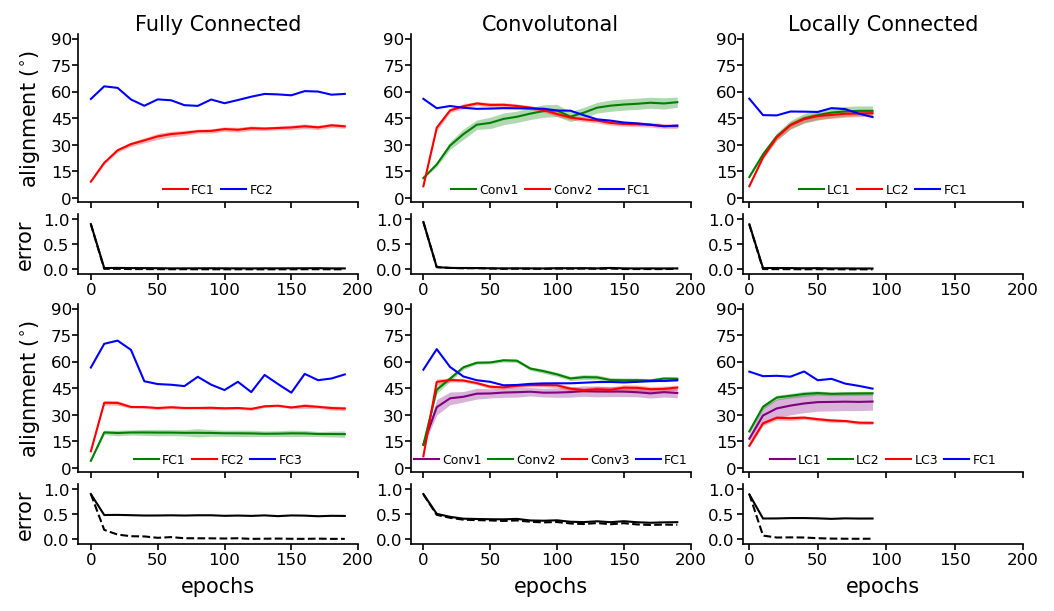

In [96]:
axes, axes_sub = make_axes()
plot_angles(axes[0], angles_1, "Fully Connected", labels=["FC1", "FC2"])
plot_angles(axes[1], angles_2, "Convolutonal", labels=["Conv1", "Conv2", "FC1"])
plot_angles(axes[2], angles_3, "Locally Connected", labels=["LC1", "LC2", "FC1"])
plot_angles(axes[3], angles_4, labels=["FC1", "FC2", "FC3"])
plot_angles(axes[4], angles_5, labels=["Conv1", "Conv2", "Conv3", "FC1"])
plot_angles(axes[5], angles_6, labels=["LC1", "LC2", "LC3", "FC1"])

plot_err(axes_sub[0], 1-acc_1)
plot_err(axes_sub[1], 1-acc_2)
plot_err(axes_sub[2], 1-acc_3)
plot_err(axes_sub[3], 1-acc_4)
plot_err(axes_sub[4], 1-acc_5)
plot_err(axes_sub[5], 1-acc_6)

format_axes(axes, axes_sub)

plt.savefig("../figs/vec_mono_alignment.pdf", bbox_inches="tight")


    

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


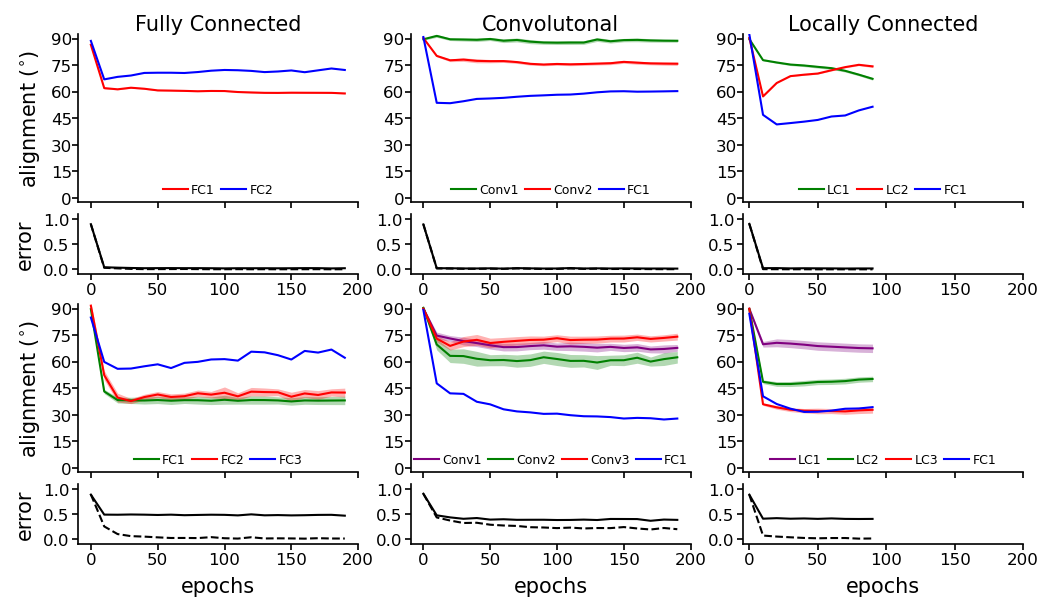

In [97]:
axes, axes_sub = make_axes()
plot_angles(axes[0], angles_7, "Fully Connected", labels=["FC1", "FC2"])
plot_angles(axes[1], angles_8, "Convolutonal", labels=["Conv1", "Conv2", "FC1"])
plot_angles(axes[2], angles_9, "Locally Connected", labels=["LC1", "LC2", "FC1"])
plot_angles(axes[3], angles_10, labels=["FC1", "FC2", "FC3"])
plot_angles(axes[4], angles_11, labels=["Conv1", "Conv2", "Conv3", "FC1"])
plot_angles(axes[5], angles_12, labels=["LC1", "LC2", "LC3", "FC1"])

plot_err(axes_sub[0], 1-acc_7)
plot_err(axes_sub[1], 1-acc_8)
plot_err(axes_sub[2], 1-acc_9)
plot_err(axes_sub[3], 1-acc_10)
plot_err(axes_sub[4], 1-acc_11)
plot_err(axes_sub[5], 1-acc_12)

format_axes(axes, axes_sub)

plt.savefig("../figs/vec_mixed_alignment.pdf", bbox_inches="tight")




In [19]:
def compute_alignment_angles_nonvec(model_dir, layers, make_model_fn, input, labels, num_epochs, epoch_step):
    batch_size = len(input)
    num_checkpoints = len(np.arange(0, num_epochs, epoch_step))
    angles = None
    loss_vals = np.zeros((num_checkpoints, 2))
    acc_vals = np.zeros((num_checkpoints, 2))
    epoch_idx = 0
    loss_fn = nn.CrossEntropyLoss(reduction="mean")
    for epoch in np.arange(0, num_epochs, epoch_step):
        print(epoch)
        checkpoint = torch.load(model_dir + "/epoch_{}.pt".format(epoch))
        model = make_model_fn()
        nonlin_layers = [i for i, layer in enumerate(model.sequential) if layer.__class__.__name__ == 'aReLU']
        #run backwards once to instantiate feedback matrix variable
        output = model(input, learning_rule="df")
        loss = loss_fn(output, labels)
        loss.backward()
        #load feedback matrix from epoch 10 if we're on epoch 0
        if epoch == 0:
            model.load_state_dict(torch.load(model_dir + "/epoch_10.pt")['model_state_dict'])
        #load real state dict
        state_dict = checkpoint['model_state_dict']
        strict = epoch > 0 #don't complain if there's no state dict if we're on epoch 0 as it's already loaded
        model.load_state_dict(state_dict, strict=strict)
        #trigger our custom code to track grads
        for layer in model.sequential: layer.custom_retain_grads = True
        
        #BP
        vnn.zero_grads(model)
        for i in nonlin_layers:
            model.sequential[i].output.grad = None
            model.sequential[i].output = None
        output = model(input, learning_rule="bp")
        loss = loss_fn(output, labels)
        loss.backward()
        g_bp = [model.sequential[i].output.grad.clone() for i in nonlin_layers]
        g_bp = [g.view(len(g), -1).numpy() for g in g_bp]
        
        #DF
        vnn.zero_grads(model)
        for i in nonlin_layers:
            model.sequential[i].output.grad = None
            model.sequential[i].output = None
        output = model(input, learning_rule="df")
        loss = loss_fn(output, labels)
        loss.backward()
        g_df = [model.sequential[i].output.grad.clone() for i in nonlin_layers]
        g_df = [g.view(len(g), -1).numpy() for g in g_df]
        
        epoch_angles = np.array([(g_bp[i]*g_df[i]).sum(axis=1)/(np.linalg.norm(g_bp[i], axis=1)*np.linalg.norm(g_df[i], axis=1))
                                 for i in range(len(g_bp))]).T
        epoch_angles = np.rad2deg(np.arccos(epoch_angles))
        if angles is None:
            angles = np.zeros((num_checkpoints, batch_size, len(nonlin_layers)))
        angles[epoch_idx] = epoch_angles
        loss_vals[epoch_idx] = [checkpoint["train_loss"], checkpoint["test_loss"]]
        acc_vals[epoch_idx] = [checkpoint["train_accuracy"], checkpoint["test_accuracy"]]
        
        epoch_idx += 1
        
    return angles, acc_vals, loss_vals



In [53]:
base_dir = "/home/davidclark/Projects/VectorizedNets/experiments/models2"

angles_nv_1, acc_nv_1, loss_nv_1 = compute_alignment_angles_nonvec(
    model_dir=base_dir + "/mnist_nonvec_fc_df_mono",
    layers=None,
    make_model_fn=lambda: nonvec_models.make_mnist_nonvec_fc(False),
    input=nn.Flatten()(mnist_data),
    labels=mnist_labels,
    num_epochs=101,
    epoch_step=10)

angles_nv_2, acc_nv_2, loss_nv_2 = compute_alignment_angles_nonvec(
    model_dir=base_dir + "/mnist_nonvec_conv_df_mono",
    layers=None,
    make_model_fn=lambda: nonvec_models.make_mnist_nonvec_conv(False),
    input=mnist_data,
    labels=mnist_labels,
    num_epochs=101,
    epoch_step=10)

angles_nv_3, acc_nv_3, loss_nv_3 = compute_alignment_angles_nonvec(
    model_dir=base_dir + "/mnist_nonvec_lc_df_mono",
    layers=None,
    make_model_fn=lambda: nonvec_models.make_mnist_nonvec_lc(False),
    input=mnist_data,
    labels=mnist_labels,
    num_epochs=101,
    epoch_step=10)

angles_nv_4, acc_nv_4, loss_nv_4 = compute_alignment_angles_nonvec(
    model_dir=base_dir + "/cifar_nonvec_fc_df_mono",
    layers=None,
    make_model_fn=lambda: nonvec_models.make_cifar_nonvec_fc(False),
    input=nn.Flatten()(cifar_data),
    labels=cifar_labels,
    num_epochs=101,
    epoch_step=10)

angles_nv_5, acc_nv_5, loss_nv_5 = compute_alignment_angles_nonvec(
    model_dir=base_dir + "/cifar_nonvec_conv_df_mono",
    layers=None,
    make_model_fn=lambda: nonvec_models.make_cifar_nonvec_conv(False),
    input=cifar_data,
    labels=cifar_labels,
    num_epochs=101,
    epoch_step=10)

angles_nv_6, acc_nv_6, loss_nv_6 = compute_alignment_angles_nonvec(
    model_dir=base_dir + "/cifar_nonvec_lc_df_mono",
    layers=None,
    make_model_fn=lambda: nonvec_models.make_cifar_nonvec_lc(False),
    input=cifar_data,
    labels=cifar_labels,
    num_epochs=101,
    epoch_step=10)

0
10
20
30
40
50
60
70
80
90
100
0


<ipython-input-19-4998e14bb694>:50: RuntimeWarning: invalid value encountered in true_divide
  epoch_angles = np.array([(g_bp[i]*g_df[i]).sum(axis=1)/(np.linalg.norm(g_bp[i], axis=1)*np.linalg.norm(g_df[i], axis=1))
<ipython-input-19-4998e14bb694>:50: RuntimeWarning: divide by zero encountered in true_divide
  epoch_angles = np.array([(g_bp[i]*g_df[i]).sum(axis=1)/(np.linalg.norm(g_bp[i], axis=1)*np.linalg.norm(g_df[i], axis=1))
<ipython-input-19-4998e14bb694>:52: RuntimeWarning: invalid value encountered in arccos
  epoch_angles = np.rad2deg(np.arccos(epoch_angles))


10
20
30
40
50
60
70
80
90
100
0
10


RuntimeError: python_error

In [21]:
angles_nv_7, acc_nv_7, loss_nv_7 = compute_alignment_angles_nonvec(
    model_dir=base_dir + "/mnist_nonvec_fc_df_mixed",
    layers=None,
    make_model_fn=lambda: nonvec_models.make_mnist_nonvec_fc(False),
    input=nn.Flatten()(mnist_data),
    labels=mnist_labels,
    num_epochs=101,
    epoch_step=10)

angles_nv_8, acc_nv_8, loss_nv_8 = compute_alignment_angles_nonvec(
    model_dir=base_dir + "/mnist_nonvec_conv_df_mixed",
    layers=None,
    make_model_fn=lambda: nonvec_models.make_mnist_nonvec_conv(False),
    input=mnist_data,
    labels=mnist_labels,
    num_epochs=101,
    epoch_step=10)

angles_nv_9, acc_nv_9, loss_nv_9 = compute_alignment_angles_nonvec(
    model_dir=base_dir + "/mnist_nonvec_lc_df_mixed",
    layers=None,
    make_model_fn=lambda: nonvec_models.make_mnist_nonvec_lc(False),
    input=mnist_data,
    labels=mnist_labels,
    num_epochs=101,
    epoch_step=10)

angles_nv_10, acc_nv_10, loss_nv_10 = compute_alignment_angles_nonvec(
    model_dir=base_dir + "/cifar_nonvec_fc_df_mixed",
    layers=None,
    make_model_fn=lambda: nonvec_models.make_cifar_nonvec_fc(False),
    input=nn.Flatten()(cifar_data),
    labels=cifar_labels,
    num_epochs=101,
    epoch_step=10)

angles_nv_11, acc_nv_11, loss_nv_11 = compute_alignment_angles_nonvec(
    model_dir=base_dir + "/cifar_nonvec_conv_df_mixed",
    layers=None,
    make_model_fn=lambda: nonvec_models.make_cifar_nonvec_conv(False),
    input=cifar_data,
    labels=cifar_labels,
    num_epochs=101,
    epoch_step=10)

angles_nv_12, acc_nv_12, loss_nv_12 = compute_alignment_angles_nonvec(
    model_dir=base_dir + "/cifar_nonvec_lc_df_mixed",
    layers=None,
    make_model_fn=lambda: nonvec_models.make_cifar_nonvec_lc(False),
    input=cifar_data,
    labels=cifar_labels,
    num_epochs=101,
    epoch_step=10)

0
10
20
30
40
50
60
70
80
90
100


<ipython-input-19-4998e14bb694>:50: RuntimeWarning: invalid value encountered in true_divide
  epoch_angles = np.array([(g_bp[i]*g_df[i]).sum(axis=1)/(np.linalg.norm(g_bp[i], axis=1)*np.linalg.norm(g_df[i], axis=1))
<ipython-input-19-4998e14bb694>:52: RuntimeWarning: invalid value encountered in arccos
  epoch_angles = np.rad2deg(np.arccos(epoch_angles))
<ipython-input-19-4998e14bb694>:50: RuntimeWarning: divide by zero encountered in true_divide
  epoch_angles = np.array([(g_bp[i]*g_df[i]).sum(axis=1)/(np.linalg.norm(g_bp[i], axis=1)*np.linalg.norm(g_df[i], axis=1))


0
10
20
30
40
50
60
70
80
90
100
0
10
20
30
40
50
60
70
80
90
100
0
10
20
30
40
50
60
70
80
90
100
0
10
20
30
40
50
60
70
80
90
100
0
10
20
30
40
50
60
70
80
90
100


0.9940909090909091
0.9895454545454545
0.995
0.9954545454545455
0.9936363636363637
1.0
1.0
1.0
0.9779829545454546
0.9801136363636364
0.9765625
0.8210227272727273
0.8203125
0.8210227272727273
0.8153409090909091
1.0
1.0
1.0
1.0


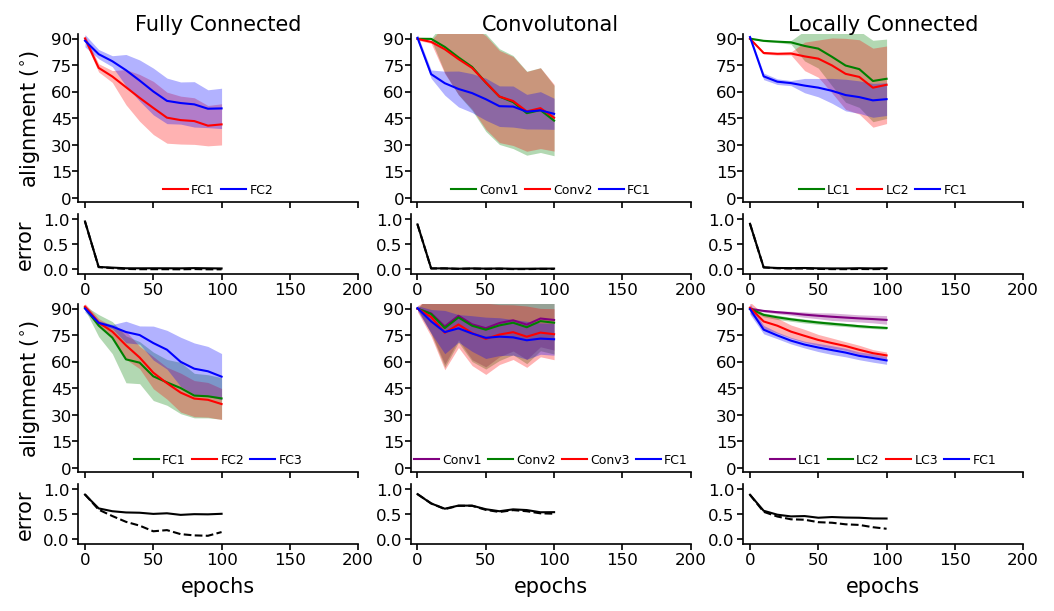

In [98]:
axes, axes_sub = make_axes()
plot_angles(axes[0], angles_nv_1, "Fully Connected", labels=["FC1", "FC2"])
plot_angles(axes[1], angles_nv_2, "Convolutonal", labels=["Conv1", "Conv2", "FC1"])
plot_angles(axes[2], angles_nv_3, "Locally Connected", labels=["LC1", "LC2", "FC1"])
plot_angles(axes[3], angles_nv_4, labels=["FC1", "FC2", "FC3"])
plot_angles(axes[4], angles_nv_5, labels=["Conv1", "Conv2", "Conv3", "FC1"])
plot_angles(axes[5], angles_nv_6, labels=["LC1", "LC2", "LC3", "FC1"])

plot_err(axes_sub[0], 1-acc_nv_1)
plot_err(axes_sub[1], 1-acc_nv_2)
plot_err(axes_sub[2], 1-acc_nv_3)
plot_err(axes_sub[3], 1-acc_nv_4)
plot_err(axes_sub[4], 1-acc_nv_5)
plot_err(axes_sub[5], 1-acc_nv_6)

format_axes(axes, axes_sub)

plt.savefig("../figs/nonvec_mono_alignment.pdf", bbox_inches="tight")


    

0.9659090909090909
0.9586363636363636
0.9786363636363636
0.9818181818181818
0.980909090909091
1.0
1.0
1.0
0.9936079545454546
0.9921875
0.9921875
0.9936079545454546
0.9921875
0.9936079545454546
0.9936079545454546
1.0
1.0
1.0
1.0


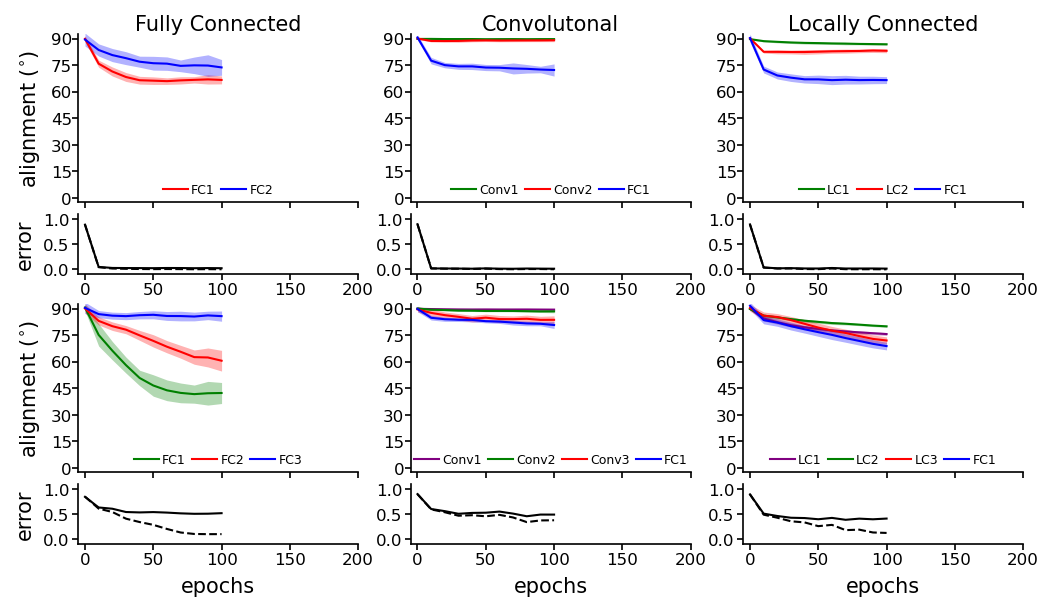

In [99]:
axes, axes_sub = make_axes()
plot_angles(axes[0], angles_nv_7, "Fully Connected", labels=["FC1", "FC2"])
plot_angles(axes[1], angles_nv_8, "Convolutonal", labels=["Conv1", "Conv2", "FC1"])
plot_angles(axes[2], angles_nv_9, "Locally Connected", labels=["LC1", "LC2", "FC1"])
plot_angles(axes[3], angles_nv_10, labels=["FC1", "FC2", "FC3"])
plot_angles(axes[4], angles_nv_11, labels=["Conv1", "Conv2", "Conv3", "FC1"])
plot_angles(axes[5], angles_nv_12, labels=["LC1", "LC2", "LC3", "FC1"])

plot_err(axes_sub[0], 1-acc_nv_7)
plot_err(axes_sub[1], 1-acc_nv_8)
plot_err(axes_sub[2], 1-acc_nv_9)
plot_err(axes_sub[3], 1-acc_nv_10)
plot_err(axes_sub[4], 1-acc_nv_11)
plot_err(axes_sub[5], 1-acc_nv_12)

format_axes(axes, axes_sub)

plt.savefig("../figs/nonvec_mixed_alignment.pdf", bbox_inches="tight")


    

In [93]:
ls


alignment_and_concentration_viz.ipynb  dfa_train_test.ipynb  prepare_data.ipynb
dfa_test.ipynb                         init_viz.ipynb        test_vnn2.ipynb
